<a href="https://colab.research.google.com/github/tdack21/cosmologia_ml/blob/main/Tarea_10_cosmoml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 10. Cosmología con Machine Learning
Tonatiuh Sánchez Madrid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import approx_fprime
from scipy.stats import chi2

In [2]:
H0 = 68  # Hubble constant in km/s/Mpc
Omega_m0 = 0.3  # Matter density parameter
Omega_L0 = 0.7  # Dark energy density parameter

# CPL parameterization for w(z)
def w(z, w0, wa):
    return w0 + wa * (z / (1 + z))

# Hubble parameter function E(z) for CPL
def E(z, w0, wa):
    return np.sqrt(Omega_m0 * (1 + z)**3 + Omega_L0 * (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z)))

# Theoretical H(z)
def H(z, w0, wa):
    return H0 * E(z, w0, wa)

# Observational data (H(z) from Cosmic Chronometers)
z_H = np.array([0.07, 0.12, 0.20, 0.28, 0.40, 0.50, 0.60, 0.80, 1.00])
H_obs = np.array([69, 68.6, 72.9, 88.8, 95, 97, 87.9, 117, 168])  # H(z) values in km/s/Mpc
H_err = np.array([19.6, 26.2, 29.6, 36.6, 17, 62, 6.1, 23.4, 17.4])  # Errors

# Chi-squared function
def chi2(w0, wa):
    H_theo = np.array([H(zi, w0, wa) for zi in z_H])
    return np.sum(((H_obs - H_theo) / H_err)**2)

In [3]:
# Función de likelihood
def likelihood(w0, wa):
    return np.exp(-0.5 * chi2(w0, wa))  # Ejemplo basado en chi2

# Función de fitness
def _fitness(x):
    w0, wa = x  # Desempaquetar los valores de w0 y wa
    if -7 < w0 < 0 and -5 < wa < 20:  # Restricciones en w0 y wa
        y = likelihood(w0, wa)  # Calcular el likelihood
        return np.round(y, 6)
    else:
        return 0

fitness = np.vectorize(_fitness, signature="(n)->()")

# Función para obtener el mejor fitness
def _get_fitness(parents, fitness):
    _fitness = fitness(parents)  # Calcular el fitness para todos los padres
    Lfitness = list(zip(parents, _fitness))  # Combinar padres con su fitness
    Lfitness.sort(key=lambda x: x[1], reverse=True)  # Ordenar por fitness
    best_parents, best_fitness = Lfitness[0]  # Obtener el mejor par
    return np.round(best_parents, 4), np.round(best_fitness, 4)

# Función de mutación
def mutate(parents, fitness_fun):
    n = len(parents)
    scores = fitness_fun(parents)  # Calcular el fitness de los padres
    id = scores > 0  # Filtrar padres con fitness válido
    scores = scores[id]
    parents = np.array(parents)[id]

    # Seleccionar padres basados en su fitness
    children_indices = np.random.choice(range(len(parents)), size=n, p=scores/scores.sum())
    children = parents[children_indices]

    # Aplicar mutación a ambos w0 y wa
    mutations = np.random.uniform(-0.5, 0.5, size=(n, 2))
    children = children + mutations

    return children.tolist()

# Algoritmo genético
def GA(parents, fitness_fun, max_gen=100):
    best_parent, best_fitness = _get_fitness(parents, fitness_fun)
    for i in range(1, max_gen):
        parents = mutate(parents, fitness_fun)
        curr_parent, curr_fitness = _get_fitness(parents, fitness_fun)
        if curr_fitness > best_fitness:
            best_parent, best_fitness = curr_parent, curr_fitness
    return best_parent, best_fitness

# Población inicial
w0_range = np.linspace(-7, 0, 20)
wa_range = np.linspace(-5, 20, 20)
ini_pob = list(zip(np.random.choice(w0_range, size=10), np.random.choice(wa_range, size=10)))

# Ejecutar el algoritmo genético
best_solution, best_fitness = GA(ini_pob, fitness)
print(f"Mejor solución: w0 = {best_solution[0]}, wa = {best_solution[1]}")
print(f"Mejor fitness: {best_fitness}")

Mejor solución: w0 = -3.4465, wa = 11.5435
Mejor fitness: 0.2354


In [4]:
# Función de likelihood (ejemplo)
def likelihood(params):
    w0, wa = params
    # Aquí va tu código para calcular el likelihood
    return np.exp(-0.5 * chi2(w0, wa))  # Ejemplo basado en chi2

# Función para calcular el Hessiano numéricamente
def compute_hessian(fun, params, epsilon=1e-5):
    n = len(params)
    hessian = np.zeros((n, n))

    # Función para calcular la primera derivada parcial
    def partial_derivative(f, x, i, epsilon):
        x_plus = x.copy()
        x_plus[i] += epsilon
        x_minus = x.copy()
        x_minus[i] -= epsilon
        return (f(x_plus) - f(x_minus)) / (2 * epsilon)

    # Calcular el Hessiano
    for i in range(n):
        for j in range(n):
            # Función para calcular la segunda derivada parcial
            def second_partial_derivative(x):
                def partial_i(x):
                    return partial_derivative(fun, x, i, epsilon)
                return partial_derivative(partial_i, x, j, epsilon)

            # Calcular el elemento (i, j) del Hessiano
            hessian[i, j] = second_partial_derivative(params)

    return hessian

# Parámetros óptimos (obtenidos del GA)
best_params = [best_solution[0], best_solution[1]]  # w0 y wa óptimos

# Calcular el Hessiano en los parámetros óptimos
hessian = compute_hessian(likelihood, best_params)

# Invertir el Hessiano para obtener la matriz de covarianza
cov_matrix = np.linalg.inv(hessian)

# Calcular la matriz de correlación
std_dev = np.diag(cov_matrix)  # Desviaciones estándar
corr_matrix = cov_matrix / np.sqrt(np.outer(std_dev, std_dev))

# Mostrar resultados
print("Matriz de covarianza:")
print(cov_matrix)
print("\nMatriz de correlación:")
print(corr_matrix)

Matriz de covarianza:
[[ -4.81613239  18.60919002]
 [ 18.60919002 -73.17408829]]

Matriz de correlación:
[[-1.          0.99128744]
 [ 0.99128744 -1.        ]]


In [5]:
# Calcular eigenvalores y eigenvectores
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Mostrar resultados
print("Eigenvalores:")
print(eigenvalues)
print("\nEigenvectores:")
print(eigenvectors)

Eigenvalores:
[ -0.07847525 -77.91174543]

Eigenvectores:
[[ 0.96908756 -0.24671706]
 [ 0.24671706  0.96908756]]


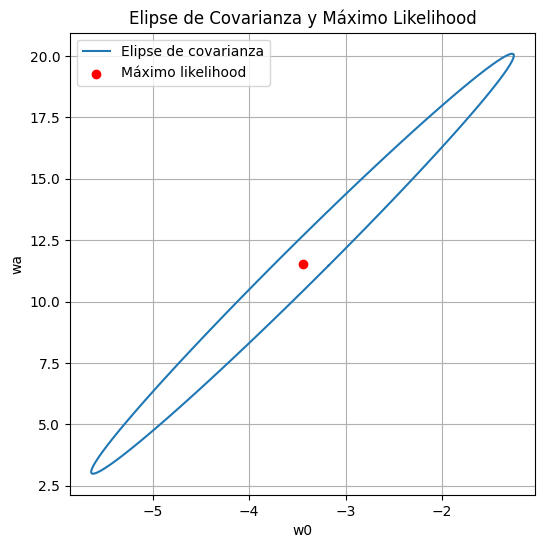

In [14]:
# Generar la elipse
angle = np.linspace(0, 2 * np.pi, 100)
a = np.sqrt(abs(eigenvalues[0]))  # Eje mayor
b = np.sqrt(abs(eigenvalues[1]))  # Eje menor

# Rotación de los eigenvectores
x_ellipse = a * np.cos(angle)
y_ellipse = b * np.sin(angle)

# Matriz de rotación
rotation_matrix = eigenvectors

# Aplicar la rotación a la elipse
rotated_ellipse = np.dot(np.column_stack((x_ellipse, y_ellipse)), rotation_matrix)
x_rotated = rotated_ellipse[:, 0]
y_rotated = rotated_ellipse[:, 1]

# Graficar la elipse
plt.figure(figsize=(6, 6))
plt.plot(x_rotated + best_params[0], y_rotated + best_params[1], label='Elipse de covarianza')
plt.scatter(best_params[0], best_params[1], color='red', label='Máximo likelihood')
plt.xlabel('w0')
plt.ylabel('wa')
plt.title('Elipse de Covarianza y Máximo Likelihood')
plt.legend()
plt.grid(True)
plt.show()
